In [1]:
import pandas as pd

# Load the datasets
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

In [2]:
# Add the 'label' column
df_fake['label'] = 1
df_true['label'] = 0

# Combine the DataFrames
df = pd.concat([df_fake, df_true], ignore_index=True)

# This code would run right after your pd.concat() line
print("Preventive Check for 'reuters':")
print(df[df['text'].str.contains('reuters', case=False, na=False)]['label'].value_counts())

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Let's see the first few rows of our combined data
print(df.head())

Preventive Check for 'reuters':
label
0    21378
1      322
Name: count, dtype: int64
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  label  
0    February 13, 2017      1  
1       April 5, 2017       0  
2  September 27, 2017       0  
3         May 22, 2017      

In [3]:
# Check for missing values in each column
print(df.isnull().sum())
# Check the class balance
print(df['label'].value_counts())
# Create the text_length column
df['text_length'] = df['text'].str.len()

# Get summary statistics grouped by label
print(df.groupby('label')['text_length'].describe())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
label
1    23481
0    21417
Name: count, dtype: int64
         count         mean          std  min     25%     50%     75%      max
label                                                                         
0      21417.0  2383.278517  1684.835730  1.0   914.0  2222.0  3237.0  29781.0
1      23481.0  2547.396235  2532.884399  1.0  1433.0  2166.0  3032.0  51794.0


In [4]:
import re # We'll need this for removing URLs and punctuation
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    """A function to clean text data and remove data leakage."""
    # Convert to lowercase
    text = text.lower()

    # FIX: Remove the word 'reuters' to prevent data leakage
    text = re.sub(r'reuters', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove stopwords
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    text = ' '.join(words)

    return text

# Apply the final function
df['cleaned_text'] = df['text'].apply(clean_text)
print("Final Cleaned Text Sample:\n", df['cleaned_text'].iloc[0])

Final Cleaned Text Sample:
 st century wire says ben stein reputable professor pepperdine university hollywood fame appearing tv shows films ferris bueller s day provocative statements judge jeanine pirro s recently discussing halt imposed president trump s executive order travel stein referred judgement th circuit court washington state coup d tat executive branch constitution stein went judges seattle political puppets judiciary political pawns watch interview complete statements note stark contrast rhetoric leftist media pundits neglect note court blocked presidential orders immigration past discuss legal efficacy halt actual text executive orderread trump news st century wire trump filessupport work subscribing member wiretv


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Split the data
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Initialize the vectorizer
# We'll limit it to the top 10,000 words for efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=10000)

# 3. Fit on train and transform both train and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of the training data matrix:", X_train_tfidf.shape)
print("Shape of the test data matrix:", X_test_tfidf.shape)

Shape of the training data matrix: (35918, 10000)
Shape of the test data matrix: (8980, 10000)


In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# 1. Initialize the model
nb_model = MultinomialNB()

# 2. Train the model
nb_model.fit(X_train_tfidf, y_train)

# 3. Make predictions on the test set
y_pred_nb = nb_model.predict(X_test_tfidf)

# 4. Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Multinomial Naïve Bayes Accuracy: {accuracy_nb:.4f}")

Multinomial Naïve Bayes Accuracy: 0.9363


In [7]:
import pandas as pd

# Get the predicted probabilities for the test set
y_pred_proba_nb = nb_model.predict_proba(X_test_tfidf)

# We are interested in the probability of the 'fake' class (which is the second column)
fake_news_probabilities = y_pred_proba_nb[:, 1]

# Print the first 5 probability scores
print(fake_news_probabilities[:5])

[7.67661265e-01 7.95648714e-03 4.37758604e-02 7.24073683e-04
 9.87228253e-01]


In [8]:
import numpy as np
import pandas as pd

# Create a DataFrame to keep labels and probabilities aligned
results_df = pd.DataFrame({'true_label': y_test, 'probability_fake': fake_news_probabilities})

# Sort the DataFrame by probability in descending order
results_df_sorted = results_df.sort_values(by='probability_fake', ascending=False)

# Display the top 5 rows
print(results_df_sorted.head())

       true_label  probability_fake
30326           1          0.999999
43911           1          0.999999
30340           1          0.999999
20808           1          0.999999
39660           1          0.999999


In [9]:
def calculate_precision_at_k(df, k_percent):
    """Calculates precision for the top K percent of predictions."""
    # Determine how many articles are in the top K%
    k_samples = int(len(df) * (k_percent / 100))

    # Slice the DataFrame to get only the top K%
    top_k_df = df.head(k_samples)

    # Calculate precision: Correctly flagged / Total flagged
    precision = top_k_df['true_label'].sum() / k_samples
    return precision

# Calculate Precision for K=10%
precision_at_10 = calculate_precision_at_k(results_df_sorted, 10)
precision_at_25 = calculate_precision_at_k(results_df_sorted, 25)
precision_at_50 = calculate_precision_at_k(results_df_sorted, 50)
precision_at_100 = calculate_precision_at_k(results_df_sorted, 100)
print(f"Precision@10% for Naïve Bayes: {precision_at_10:.4f}")
print(f"Precision@25% for Naïve Bayes: {precision_at_25:.4f}")
print(f"Precision@50% for Naïve Bayes: {precision_at_50:.4f}")
print(f"Precision@100% for Naïve Bayes: {precision_at_100:.4f}")

Precision@10% for Naïve Bayes: 1.0000
Precision@25% for Naïve Bayes: 0.9969
Precision@50% for Naïve Bayes: 0.9405
Precision@100% for Naïve Bayes: 0.5229


In [10]:
import numpy as np

# Get the feature names from the vectorizer
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Get the log probabilities for each class from the trained model
log_prob_real = nb_model.feature_log_prob_[0]
log_prob_fake = nb_model.feature_log_prob_[1]

# Get the top 20 words for each class
top_real_words = feature_names[np.argsort(log_prob_real)[::-1][:20]]
top_fake_words = feature_names[np.argsort(log_prob_fake)[::-1][:20]]

print("Top 20 words for REAL news:")
print(top_real_words)
print("\nTop 20 words for FAKE news:")
print(top_fake_words)

Top 20 words for REAL news:
['said' 'trump' 'president' 'house' 'government' 'state' 'states'
 'washington' 'united' 'republican' 'trumps' 'new' 'told' 'north'
 'minister' 'senate' 'election' 'party' 'korea' 'security']

Top 20 words for FAKE news:
['trump' 'clinton' 'people' 'obama' 'president' 'just' 'hillary' 'said'
 'like' 'donald' 'news' 'white' 'america' 'don' 'video' 'know' 'time'
 'new' 'campaign' 'image']


In [11]:
# The lists from your output
top_real_words = ['said', 'trump', 'president', 'house', 'government', 'state', 'states', 'washington', 'united', 'republican', 'trumps', 'new', 'told', 'north', 'minister', 'senate', 'election', 'party', 'korea', 'security']
top_fake_words = ['trump', 'clinton', 'people', 'obama', 'president', 'just', 'hillary', 'said', 'like', 'donald', 'news', 'white', 'america', 'don', 'video', 'know', 'time', 'new', 'campaign', 'image']

# Find words that are in one list but not the other
real_unique_words = list(set(top_real_words) - set(top_fake_words))
fake_unique_words = list(set(top_fake_words) - set(top_real_words))

print("Words unique to the REAL news list:")
print(real_unique_words)
print("\nWords unique to the FAKE news list:")
print(fake_unique_words)

Words unique to the REAL news list:
['security', 'government', 'state', 'north', 'republican', 'election', 'told', 'minister', 'house', 'senate', 'states', 'washington', 'korea', 'united', 'party', 'trumps']

Words unique to the FAKE news list:
['time', 'video', 'image', 'just', 'donald', 'obama', 'like', 'america', 'clinton', 'people', 'hillary', 'white', 'don', 'campaign', 'know', 'news']


In [12]:
import re
import pandas as pd

# Let's use the original text for accurate counts before cleaning
real_news_corpus = df[df['label'] == 0]['text']
fake_news_corpus = df[df['label'] == 1]['text']

# Combine your unique word lists
words_to_check = real_unique_words + fake_unique_words

results = []
for word in words_to_check:
    # Count occurrences in each corpus (case-insensitive)
    real_count = real_news_corpus.str.count(word, flags=re.IGNORECASE).sum()
    fake_count = fake_news_corpus.str.count(word, flags=re.IGNORECASE).sum()
    difference = abs(real_count - fake_count)

    results.append({
        'word': word,
        'real_count': real_count,
        'fake_count': fake_count,
        'difference': difference
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)

# Apply your 15,000 difference threshold
concerning_words_df = results_df[results_df['difference'] > 15000]

print("--- Systematic Check for Concerning Words ---")
if concerning_words_df.empty:
    print("No words exceeded the 15,000 difference threshold.")
else:
    print(concerning_words_df)

--- Systematic Check for Concerning Words ---
       word  real_count  fake_count  difference
2     state       48153       31454       16699
19     just        9459       26489       17030
23  america       10113       29602       19489
28      don       21190       42252       21062


random forest model


In [13]:
from sklearn.decomposition import TruncatedSVD

# Initialize TruncatedSVD
svd = TruncatedSVD(n_components=300, random_state=42)

# Fit on the training data and transform both sets
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

print("Original training data shape:", X_train_tfidf.shape)
print("New training data shape:", X_train_svd.shape)

Original training data shape: (35918, 10000)
New training data shape: (35918, 300)


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Initialize the model
# We'll use n_jobs=-1 to use all available CPU cores and speed up training
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model
print("Training the Random Forest model... (This may take a minute or two)")
rf_model.fit(X_train_svd, y_train)
print("Training complete.")

# 3. Make predictions and calculate accuracy
y_pred_rf = rf_model.predict(X_test_svd)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

Training the Random Forest model... (This may take a minute or two)
Training complete.
Random Forest Accuracy: 0.9629


In [15]:
# 1. Get the probabilities from the Random Forest model
y_pred_proba_rf = rf_model.predict_proba(X_test_svd)
fake_news_probabilities_rf = y_pred_proba_rf[:, 1]

# 2. Create and sort the results DataFrame
results_df_rf = pd.DataFrame({'true_label': y_test, 'probability_fake': fake_news_probabilities_rf})
results_df_rf_sorted = results_df_rf.sort_values(by='probability_fake', ascending=False)

# 3. Calculate Precision@K using our existing function
precision_at_10_rf = calculate_precision_at_k(results_df_rf_sorted, 10)
precision_at_25_rf = calculate_precision_at_k(results_df_rf_sorted, 25)
precision_at_50_rf = calculate_precision_at_k(results_df_rf_sorted, 50)
precision_at_100_rf = calculate_precision_at_k(results_df_rf_sorted, 100)

print(f"Precision@10% for Random Forest: {precision_at_10_rf:.4f}")
print(f"Precision@25% for Random Forest: {precision_at_25_rf:.4f}")
print(f"Precision@50% for Random Forest: {precision_at_50_rf:.4f}")
print(f"Precision@100% for Random Forest: {precision_at_100_rf:.4f}")

Precision@10% for Random Forest: 1.0000
Precision@25% for Random Forest: 0.9987
Precision@50% for Random Forest: 0.9829


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize a new vectorizer with limited features
interpretable_vectorizer = TfidfVectorizer(max_features=5000)

# 2. Fit and transform the data
X_train_interp = interpretable_vectorizer.fit_transform(X_train)
X_test_interp = interpretable_vectorizer.transform(X_test)

print("Shape of new interpretable training data:", X_train_interp.shape)


Shape of new interpretable training data: (35918, 5000)


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Initialize a new Random Forest model
rf_model_interp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Train the model on the new interpretable data
print("Training the interpretable Random Forest model...")
rf_model_interp.fit(X_train_interp, y_train)
print("Training complete.")

# 3. Make predictions and calculate accuracy
y_pred_rf_interp = rf_model_interp.predict(X_test_interp)
accuracy_rf_interp = accuracy_score(y_test, y_pred_rf_interp)
print(f"Interpretable Random Forest Accuracy: {accuracy_rf_interp:.4f}")


Training the interpretable Random Forest model...
Training complete.
Interpretable Random Forest Accuracy: 0.9861


In [19]:
# 1. Get the probabilities from the Random Forest model
y_pred_proba_rf_int = rf_model_interp.predict_proba(X_test_interp)
fake_news_probabilities_rf_int = y_pred_proba_rf_int[:, 1]

# 2. Create and sort the results DataFrame
results_df_rf_int = pd.DataFrame({'true_label': y_test, 'probability_fake': fake_news_probabilities_rf_int})
results_df_rf_sorted_int = results_df_rf_int.sort_values(by='probability_fake', ascending=False)

# 3. Calculate Precision@K using our existing function
precision_at_10_rf_int = calculate_precision_at_k(results_df_rf_sorted_int, 10)
precision_at_25_rf_int = calculate_precision_at_k(results_df_rf_sorted_int, 25)
precision_at_50_rf_int = calculate_precision_at_k(results_df_rf_sorted_int, 50)
precision_at_100_rf_int = calculate_precision_at_k(results_df_rf_sorted_int, 100)

print(f"Precision@10% for Random Forest: {precision_at_10_rf_int:.4f}")
print(f"Precision@25% for Random Forest: {precision_at_25_rf_int:.4f}")
print(f"Precision@50% for Random Forest: {precision_at_50_rf_int:.4f}")
print(f"Precision@100% for Random Forest: {precision_at_100_rf_int:.4f}")

Precision@10% for Random Forest: 1.0000
Precision@25% for Random Forest: 1.0000
Precision@50% for Random Forest: 0.9984
Precision@100% for Random Forest: 0.5229


In [1]:
import pandas as pd
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Define the common cleaning function
def clean_text(text):
    """A function to clean text data and remove data leakage."""
    if isinstance(text, float): # Handle potential NaN values
        return ""
    text = text.lower()
    text = re.sub(r'reuters', '', text) # Remove Reuters
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Remove non-alphabetic
    words = text.split()
    words = [word for word in words if word not in ENGLISH_STOP_WORDS]
    text = ' '.join(words)
    return text

# Load and process Kaggle dataset
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

# Add the 'label' column (1: Fake, 0: True)
df_fake['label'] = 1
df_true['label'] = 0

# Combine, keep only necessary columns, and clean
df_kaggle = pd.concat([df_fake, df_true], ignore_index=True)
df_kaggle = df_kaggle[['text', 'label']].copy()
df_kaggle['cleaned_text'] = df_kaggle['text'].apply(clean_text)

print(f"Kaggle Dataset Size: {len(df_kaggle)}")
print(df_kaggle[['text', 'label', 'cleaned_text']].head(2))

Kaggle Dataset Size: 44898
                                                text  label  \
0  Donald Trump just couldn t wish all Americans ...      1   
1  House Intelligence Committee Chairman Devin Nu...      1   

                                        cleaned_text  
0  donald trump just couldn t wish americans happ...  
1  house intelligence committee chairman devin nu...  


In [2]:
import numpy as np

# Define the column names for the LIAR dataset files
liar_columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info',
                'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts',
                'mostly_true_counts', 'pants_on_fire_counts', 'context']

# Load the LIAR dataset parts
df_liar_train = pd.read_csv('/content/train.tsv', sep='\t', names=liar_columns)
df_liar_test = pd.read_csv('/content/test.tsv', sep='\t', names=liar_columns)
df_liar_val = pd.read_csv('/content/valid.tsv', sep='\t', names=liar_columns)

# Concatenate all LIAR parts
df_liar_raw = pd.concat([df_liar_train, df_liar_test, df_liar_val], ignore_index=True)

# Function to convert LIAR's 6 fine-grained labels to binary (0=True, 1=Fake)
# {true, mostly-true, half-true} -> 0 (Real); {barely-true, false, pants-fire} -> 1 (Fake)
def convert_liar_label(label):
    if label in ['true', 'mostly-true', 'half-true']:
        return 0  # Real
    elif label in ['barely-true', 'false', 'pants-fire']:
        return 1  # Fake
    return np.nan

# Apply binary labeling and cleaning
df_liar_raw['label'] = df_liar_raw['label'].apply(convert_liar_label)
df_liar_raw = df_liar_raw.rename(columns={'statement': 'text'})

# Select, clean, and filter LIAR data
df_liar = df_liar_raw[['text', 'label']].copy()
df_liar['cleaned_text'] = df_liar['text'].apply(clean_text)

# Drop any rows where the label might be NaN after conversion (should be none, but for safety)
df_liar = df_liar.dropna(subset=['label'])

print(f"LIAR Dataset Size: {len(df_liar)}")
print(df_liar[['text', 'label', 'cleaned_text']].head(2))

LIAR Dataset Size: 12791
                                                text  label  \
0  Says the Annies List political group supports ...      1   
1  When did the decline of coal start? It started...      0   

                                        cleaned_text  
0  says annies list political group supports thir...  
1  did decline coal start started natural gas too...  


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# Combine the two major datasets
df_combined = pd.concat([df_kaggle, df_liar], ignore_index=True)

# Shuffle the combined dataset
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"--- Combined Dataset Summary ---")
print(f"Total size: {len(df_combined)}")
print("New Class Balance:")
print(df_combined['label'].value_counts())
print("\n--------------------------------")

# 1. Split the data
X = df_combined['cleaned_text']
y = df_combined['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 2. Initialize and apply the TF-IDF vectorizer (max_features=10000)
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# 3. Apply TruncatedSVD for Random Forest model
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

# 4. Vectorization (5k features for the Interpretable Random Forest model)
tfidf_vectorizer_5k = TfidfVectorizer(max_features=7000)
X_train_interp = tfidf_vectorizer_5k.fit_transform(X_train)
X_test_interp = tfidf_vectorizer_5k.transform(X_test)

print(f"Final training data shape (TF-IDF): {X_train_tfidf.shape}")
print(f"Final training data shape (SVD): {X_train_svd.shape}")
print(f"Training data shape (5k features - Interpretable): {X_train_interp.shape}")

--- Combined Dataset Summary ---
Total size: 57689
New Class Balance:
label
1    29138
0    28551
Name: count, dtype: int64

--------------------------------
Final training data shape (TF-IDF): (46151, 10000)
Final training data shape (SVD): (46151, 300)
Training data shape (5k features - Interpretable): (46151, 7000)


In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- 1. Multinomial Naïve Bayes (10k features) ---
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"1. Multinomial Naïve Bayes Accuracy (Combined, 10k features): {accuracy_nb:.4f}")

# --- 2. Random Forest (300 SVD components) ---
rf_model_svd = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_svd.fit(X_train_svd, y_train)
y_pred_rf_svd = rf_model_svd.predict(X_test_svd)
accuracy_rf_svd = accuracy_score(y_test, y_pred_rf_svd)
print(f"2. Random Forest Accuracy (Combined, 300 SVD components): {accuracy_rf_svd:.4f}")

# --- 3. Improved Random Forest (5k features) ---
rf_model_interp = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model_interp.fit(X_train_interp, y_train)
y_pred_rf_interp = rf_model_interp.predict(X_test_interp)
accuracy_rf_interp = accuracy_score(y_test, y_pred_rf_interp)
print(f"3. Random Forest Accuracy (Combined, 5k features, Interpretable): {accuracy_rf_interp:.4f}")

1. Multinomial Naïve Bayes Accuracy (Combined, 10k features): 0.8470
2. Random Forest Accuracy (Combined, 300 SVD components): 0.8768
3. Random Forest Accuracy (Combined, 5k features, Interpretable): 0.8969


--- Comprehensive Model Evaluation on Combined Dataset ---

################ Naive Bayes (10k TF-IDF) ################

Classification Report:
               precision    recall  f1-score   support

True News (0)       0.84      0.85      0.85      5710
Fake News (1)       0.85      0.84      0.85      5828

     accuracy                           0.85     11538
    macro avg       0.85      0.85      0.85     11538
 weighted avg       0.85      0.85      0.85     11538



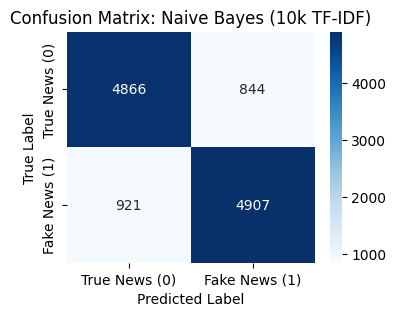

Precision@K Scores:
P@10%: 0.9991
P@25%: 0.9917
P@50%: 0.8525
P@75%: 0.6681

################ Random Forest (300 SVD) ################

Classification Report:
               precision    recall  f1-score   support

True News (0)       0.86      0.89      0.88      5710
Fake News (1)       0.89      0.86      0.88      5828

     accuracy                           0.88     11538
    macro avg       0.88      0.88      0.88     11538
 weighted avg       0.88      0.88      0.88     11538



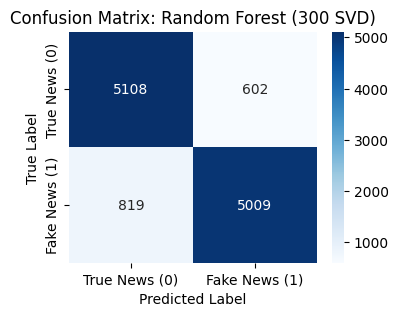

Precision@K Scores:
P@10%: 0.9991
P@25%: 0.9965
P@50%: 0.8826
P@75%: 0.6711

################ Random Forest (5k Features) ################

Classification Report:
               precision    recall  f1-score   support

True News (0)       0.88      0.91      0.90      5710
Fake News (1)       0.91      0.88      0.90      5828

     accuracy                           0.90     11538
    macro avg       0.90      0.90      0.90     11538
 weighted avg       0.90      0.90      0.90     11538



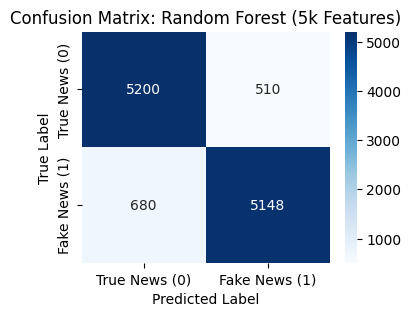

Precision@K Scores:
P@10%: 0.9957
P@25%: 0.9962
P@50%: 0.9012
P@75%: 0.6711


--- ALL MODEL PERFORMANCE SUMMARY ---
| Model                       |   Accuracy |   Precision (Fake) |   Recall (Fake) |   F1-Score (Fake) |   P@10% |   P@25% |   P@50% |   P@75% |
|:----------------------------|-----------:|-------------------:|----------------:|------------------:|--------:|--------:|--------:|--------:|
| Naive Bayes (10k TF-IDF)    |     0.847  |             0.8532 |          0.842  |            0.8476 |  0.9991 |  0.9917 |  0.8525 |  0.6681 |
| Random Forest (300 SVD)     |     0.8768 |             0.8927 |          0.8595 |            0.8758 |  0.9991 |  0.9965 |  0.8826 |  0.6711 |
| Random Forest (5k Features) |     0.8969 |             0.9099 |          0.8833 |            0.8964 |  0.9957 |  0.9962 |  0.9012 |  0.6711 |


In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Define the Precision@K function (needed again for a complete script) ---
def calculate_precision_at_k(df, k_percent):
    """Calculates precision for the top K percent of predictions."""
    k_samples = int(len(df) * (k_percent / 100))
    if k_samples == 0:
        return 0.0

    top_k_df = df.head(k_samples)
    # Precision: Correctly flagged (True Positives) / Total flagged
    precision = top_k_df['true_label'].sum() / k_samples
    return precision

# Define the models, predictors, and test data for iteration
models = {
    'Naive Bayes (10k TF-IDF)': (nb_model, X_test_tfidf),
    'Random Forest (300 SVD)': (rf_model_svd, X_test_svd),
    'Random Forest (5k Features)': (rf_model_interp, X_test_interp)
}

# Store all results
all_metrics = []
K_values = [10, 25, 50, 75]
CLASS_NAMES = ['True News (0)', 'Fake News (1)']

# --- 2. Iterate, Predict, and Calculate Metrics for Each Model ---

print("--- Comprehensive Model Evaluation on Combined Dataset ---")

for model_name, (model, X_test_data) in models.items():
    print(f"\n################ {model_name} ################")

    # Make predictions
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)
    fake_news_probabilities = y_pred_proba[:, 1]

    # 2a. Calculate Standard Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=1) # Focus on the 'Fake' class (label 1)

    all_metrics.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision (Fake)': precision,
        'Recall (Fake)': recall,
        'F1-Score (Fake)': f1_score
    })

    # Print Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=CLASS_NAMES))

    # 2b. Confusion Matrix and Heatmap
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # 2c. Precision@K Analysis
    df_results = pd.DataFrame({'true_label': y_test, 'probability_fake': fake_news_probabilities})
    df_results_sorted = df_results.sort_values(by='probability_fake', ascending=False)

    print("Precision@K Scores:")
    pk_scores = {}
    for k in K_values:
        pk = calculate_precision_at_k(df_results_sorted, k)
        pk_scores[f'P@{k}%'] = pk
        print(f"P@{k}%: {pk:.4f}")

    all_metrics[-1].update(pk_scores)

# --- 3. Final Summary Table (All Standard Metrics) ---

print("\n\n--- ALL MODEL PERFORMANCE SUMMARY ---")
summary_df = pd.DataFrame(all_metrics).set_index('Model').round(4)
print(summary_df.to_markdown())